<a href="https://colab.research.google.com/github/iMrugesh9/Regression-Capstone-Project-Retail-sales-prediction/blob/main/Retail_Sales_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Sales Prediction : Predicting sales of a major store chain Rossmann</u></b>

## <b> Problem Description </b>

### Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

### You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

## <b> Data Description </b>

### <b>Rossmann Stores Data.csv </b> - historical data including Sales
### <b>store.csv </b> - supplemental information about the stores


### <b><u>Data fields</u></b>
### Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* #### Id - an Id that represents a (Store, Date) duple within the test set
* #### Store - a unique Id for each store
* #### Sales - the turnover for any given day (this is what you are predicting)
* #### Customers - the number of customers on a given day
* #### Open - an indicator for whether the store was open: 0 = closed, 1 = open
* #### StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* #### SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* #### StoreType - differentiates between 4 different store models: a, b, c, d
* #### Assortment - describes an assortment level: a = basic, b = extra, c = extended
* #### CompetitionDistance - distance in meters to the nearest competitor store
* #### CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* #### Promo - indicates whether a store is running a promo on that day
* #### Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* #### Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* #### PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [1]:
#important libraries imported
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats 
from datetime import date
import warnings
warnings.filterwarnings('ignore')

from numpy import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from scipy.stats import zscore
import missingno as msno
import xgboost as xg
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV


In [2]:
#mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#loading the dataset
dataset_store=pd.read_csv('/content/drive/MyDrive/EDA/SL_Regr/store.csv')
dataset_sales_data=pd.read_csv('/content/drive/MyDrive/EDA/SL_Regr/Rossmann_Stores_Data.csv')

Firstly we will look at both the datasets to understand the variables involved and try to get the first impression about the features and target variables.

# Data Reading 

In [4]:
#dataset reading
dataset_store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [5]:
dataset_store.tail()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN
1114,1115,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


In [6]:
dataset_sales_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [7]:
dataset_sales_data.tail()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1
1017208,1115,2,2013-01-01,0,0,0,0,a,1


In [8]:
# Length of the historical sales dataset
dataset_sales_data.Store.value_counts()
dataset_sales_data.shape

(1017209, 9)

As we can see above there are two datasets with a store IDs as a common column for both of them.
So before starting evaluating we should merge the datasets on Store column. 

In [9]:
#merging the two datasets
Dataset=pd.merge(dataset_store,dataset_sales_data,on='Store')
Dataset.head(5)


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,5,2015-07-31,5263,555,1,1,0,1
1,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,4,2015-07-30,5020,546,1,1,0,1
2,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,3,2015-07-29,4782,523,1,1,0,1
3,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2,2015-07-28,5011,560,1,1,0,1
4,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,1,2015-07-27,6102,612,1,1,0,1


Next we will look for description and summaries of dataset to see number of  missing values and to get the general idea about the distribution of values and the data types of the variables involved.

In [10]:
# description and summary of the variables involved
Dataset.describe(include='all')

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
count,1.017209e+06,1017209,1017209,1.014567e+06,693861.000000,693861.000000,1.017209e+06,509178.000000,509178.000000,509178,1.017209e+06,1017209,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1017209,1.017209e+06
unique,NaN,4,3,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,942,NaN,NaN,NaN,NaN,5,NaN
top,NaN,a,a,NaN,NaN,NaN,NaN,NaN,NaN,"Jan,Apr,Jul,Oct",NaN,2015-07-31,NaN,NaN,NaN,NaN,0,NaN
freq,NaN,551627,537445,NaN,NaN,NaN,NaN,NaN,NaN,293122,NaN,1115,NaN,NaN,NaN,NaN,855087,NaN
mean,5.584297e+02,NaN,NaN,5.430086e+03,7.222866,2008.690228,5.005638e-01,23.269093,2011.752774,NaN,3.998341e+00,NaN,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,NaN,1.786467e-01
std,3.219087e+02,NaN,NaN,7.715324e+03,3.211832,5.992644,4.999999e-01,14.095973,1.662870,NaN,1.997391e+00,NaN,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,NaN,3.830564e-01
min,1.000000e+00,NaN,NaN,2.000000e+01,1.000000,1900.000000,0.000000e+00,1.000000,2009.000000,NaN,1.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00
25%,2.800000e+02,NaN,NaN,7.100000e+02,4.000000,2006.000000,0.000000e+00,13.000000,2011.000000,NaN,2.000000e+00,NaN,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,NaN,0.000000e+00
50%,5.580000e+02,NaN,NaN,2.330000e+03,8.000000,2010.000000,1.000000e+00,22.000000,2012.000000,NaN,4.000000e+00,NaN,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,NaN,0.000000e+00
75%,8.380000e+02,NaN,NaN,6.890000e+03,10.000000,2013.000000,1.000000e+00,37.000000,2013.000000,NaN,6.000000e+00,NaN,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,NaN,0.000000e+00


In [11]:
# information of variables involved
Dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   StoreType                  1017209 non-null  object 
 2   Assortment                 1017209 non-null  object 
 3   CompetitionDistance        1014567 non-null  float64
 4   CompetitionOpenSinceMonth  693861 non-null   float64
 5   CompetitionOpenSinceYear   693861 non-null   float64
 6   Promo2                     1017209 non-null  int64  
 7   Promo2SinceWeek            509178 non-null   float64
 8   Promo2SinceYear            509178 non-null   float64
 9   PromoInterval              509178 non-null   object 
 10  DayOfWeek                  1017209 non-null  int64  
 11  Date                       1017209 non-null  object 
 12  Sales                      1017209 non-null  int64  
 13  Customers   

As we can see that there are 9 Numeric variables and 7 object data type variables for every Store ID and corresponding numeric sales value.
There are 1017209 different sales entries, but there are several Null values in CompetitionOpenSinceMonth/Year columns and PromoSinceWeek/Year/Interval as well.
So further data imputation/ data cleaning is required.

# Data Scrubbing

First of all we will convert the date values in Date column into datetime datatype to improve usability.

In [12]:
# converting the date values into datetime data type
Dataset['Date']=pd.to_datetime(Dataset['Date'])
Dataset

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,5,2015-07-31,5263,555,1,1,0,1
1,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,4,2015-07-30,5020,546,1,1,0,1
2,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,3,2015-07-29,4782,523,1,1,0,1
3,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2,2015-07-28,5011,560,1,1,0,1
4,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,1,2015-07-27,6102,612,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1115,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec",6,2013-01-05,4771,339,1,0,0,1
1017205,1115,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec",5,2013-01-04,4540,326,1,0,0,1
1017206,1115,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec",4,2013-01-03,4297,300,1,0,0,1
1017207,1115,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec",3,2013-01-02,3697,305,1,0,0,1


In [13]:
type(Dataset.Date[0])

pandas._libs.tslibs.timestamps.Timestamp

## Null Value Treatment

As we seen earlier, there are Null values present in some columns, so we will see if there pattern exists for those columns 

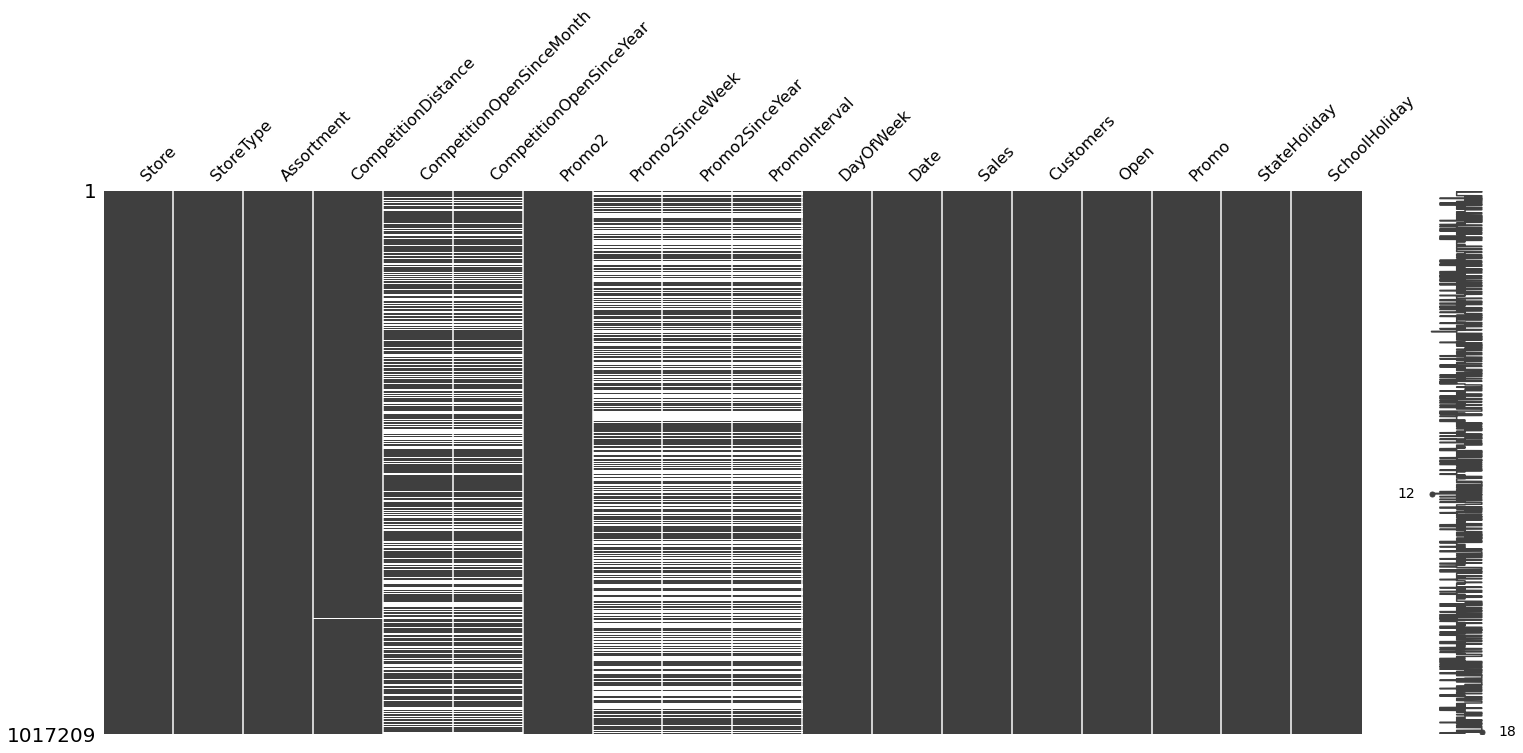

In [14]:
# looking pattern of missing values
msno.matrix(Dataset)

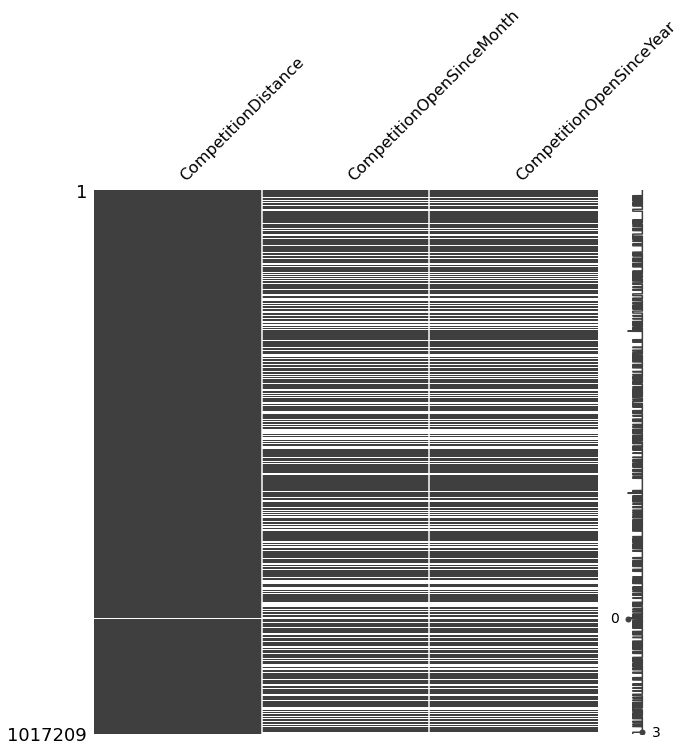

In [15]:
msno.matrix(Dataset[['CompetitionDistance','CompetitionOpenSinceMonth','CompetitionOpenSinceYear']],figsize=(10,10))
plt.yticks(fontsize=18)
plt.show()


 As we can see, Promo2SinceWeek/Year/PromoInterval have Missing values in same rows.Also CompititionSinceMonth/Year also has same pattern for missing  Rows.


There is one speculation about missing values in Promo2SinceWeek/Year/PromoInterval columns, that these null values are for the rows where Promo 
value is 0, i.e. there is No promotion. 

So First we will check that next. 





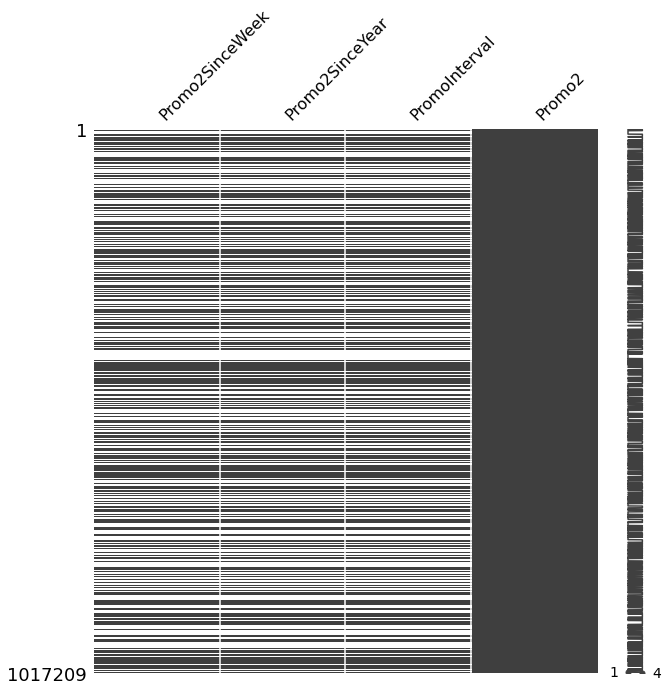

In [16]:
msno.matrix(Dataset[['Promo2SinceWeek','Promo2SinceYear','PromoInterval','Promo2']],figsize=(10,10))
plt.yticks(fontsize=18)
plt.show()


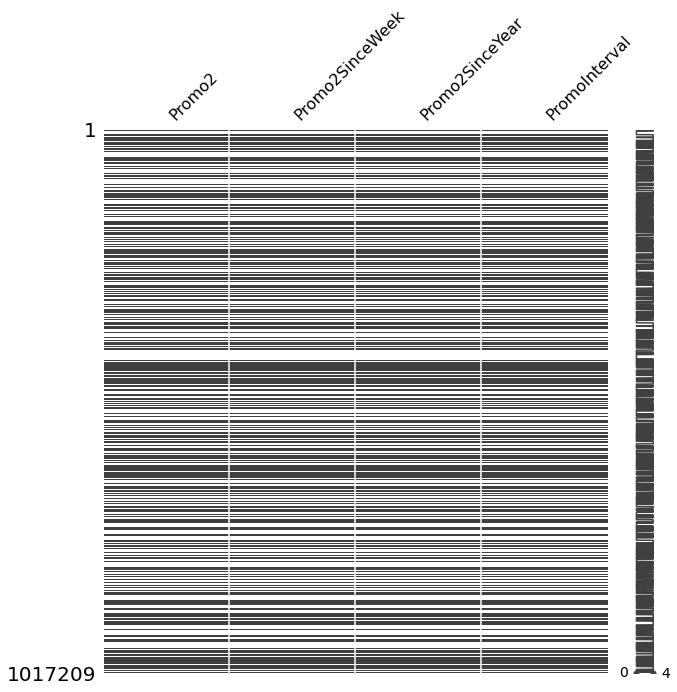

In [17]:
# checking similarity between missing values in
# Promo2SinceWeek/Month/PromoInterval and where Promo=0 rows
Promo2df=Dataset[['Promo2','Promo2SinceWeek','Promo2SinceYear','PromoInterval']]
Promo2df['Promo2'].replace(0,np.nan,inplace=True)
msno.matrix(Promo2df,figsize=(10,10))


As expected PromoSinceWeek/Year and PromoInterval has Null values where Promo2 is 0, as in there is no additional Promotion, which makes sense. So further these Null values will be converted to 0.

In addition CompetitionDistance has some Null values, which can be replaced as 0, assuming there is No competition.

Now to use Promo2SinceWeek/Year values properly, Total Week can be derived using date of the sale data and concluding with one useful value.

In [18]:
#extracting date,year,month,week from datetime data
Dataset['Date_year']=pd.DatetimeIndex(Dataset['Date']).year
Dataset['Date_month']=pd.DatetimeIndex(Dataset['Date']).month
Dataset['Date_week']=pd.DatetimeIndex(Dataset['Date']).week
Dataset['Date_day']=pd.DatetimeIndex(Dataset['Date']).day
Dataset.drop('Date',axis=1,inplace=True)
Dataset

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,...,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Date_year,Date_month,Date_week,Date_day
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,...,5263,555,1,1,0,1,2015,7,31,31
1,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,...,5020,546,1,1,0,1,2015,7,31,30
2,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,...,4782,523,1,1,0,1,2015,7,31,29
3,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,...,5011,560,1,1,0,1,2015,7,31,28
4,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,...,6102,612,1,1,0,1,2015,7,31,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1115,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec",...,4771,339,1,0,0,1,2013,1,1,5
1017205,1115,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec",...,4540,326,1,0,0,1,2013,1,1,4
1017206,1115,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec",...,4297,300,1,0,0,1,2013,1,1,3
1017207,1115,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec",...,3697,305,1,0,0,1,2013,1,1,2


In [19]:
#counting total weeks since promo till date of sale
Dataset['Promo2SinceWeek_Total']=(Dataset['Date_year']-Dataset['Promo2SinceYear'])*52+(Dataset['Date_week']-Dataset['Promo2SinceWeek'])
Dataset['Promo2SinceWeek_Total'].replace(np.nan,0,inplace=True)
Dataset.loc[Dataset['Promo2SinceWeek_Total']<0,'Promo2SinceWeek_Total']=0
# replacing nan values in CompetitionDistance and PromoInterval with 0 
Dataset['PromoInterval'].replace(np.nan,0,inplace=True)
Dataset['CompetitionDistance'].replace(np.nan,0,inplace=True)
Dataset.drop(['Promo2SinceYear','Promo2SinceWeek'],axis=1,inplace=True)
Dataset


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,PromoInterval,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Date_year,Date_month,Date_week,Date_day,Promo2SinceWeek_Total
0,1,c,a,1270.0,9.0,2008.0,0,0,5,5263,555,1,1,0,1,2015,7,31,31,0.0
1,1,c,a,1270.0,9.0,2008.0,0,0,4,5020,546,1,1,0,1,2015,7,31,30,0.0
2,1,c,a,1270.0,9.0,2008.0,0,0,3,4782,523,1,1,0,1,2015,7,31,29,0.0
3,1,c,a,1270.0,9.0,2008.0,0,0,2,5011,560,1,1,0,1,2015,7,31,28,0.0
4,1,c,a,1270.0,9.0,2008.0,0,0,1,6102,612,1,1,0,1,2015,7,31,27,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1115,d,c,5350.0,NaN,NaN,1,"Mar,Jun,Sept,Dec",6,4771,339,1,0,0,1,2013,1,1,5,31.0
1017205,1115,d,c,5350.0,NaN,NaN,1,"Mar,Jun,Sept,Dec",5,4540,326,1,0,0,1,2013,1,1,4,31.0
1017206,1115,d,c,5350.0,NaN,NaN,1,"Mar,Jun,Sept,Dec",4,4297,300,1,0,0,1,2013,1,1,3,31.0
1017207,1115,d,c,5350.0,NaN,NaN,1,"Mar,Jun,Sept,Dec",3,3697,305,1,0,0,1,2013,1,1,2,31.0


Next we will see Number of Null values remaining in the Total dataset for each column

In [20]:
#counding % Null values
cols=Dataset.columns
NA_values={}
for col in cols:
  Temp=Dataset[col].isna().value_counts()
  False_count=Temp[Temp.index==0][0]
  True_count=Dataset.shape[0]-False_count  
  NA_values[col]=True_count*100/Dataset.shape[0]
NA_vals=pd.DataFrame(NA_values.values(),NA_values.keys())
NA_vals.columns=['%_NA_values']
NA_vals.sort_values(by="%_NA_values",ascending=False)




,%_NA_values
CompetitionOpenSinceMonth,31.787764
CompetitionOpenSinceYear,31.787764
Store,0.000000
Open,0.000000
Date_day,0.000000
Date_week,0.000000
Date_month,0.000000
Date_year,0.000000
SchoolHoliday,0.000000
StateHoliday,0.000000


CompitionOpenSinceMonth/Year has lot of missing values(31%) although CompititionDitance values for such rows Exist, So CompeitionSinceMonth/Year are dropped.

In [21]:
#dropping columns with high number of missing values
Dataset.drop(['CompetitionOpenSinceMonth','CompetitionOpenSinceYear'],axis=1,inplace=True)
Dataset_viz=Dataset.copy()
Dataset

,Store,StoreType,Assortment,CompetitionDistance,Promo2,PromoInterval,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Date_year,Date_month,Date_week,Date_day,Promo2SinceWeek_Total
0,1,c,a,1270.0,0,0,5,5263,555,1,1,0,1,2015,7,31,31,0.0
1,1,c,a,1270.0,0,0,4,5020,546,1,1,0,1,2015,7,31,30,0.0
2,1,c,a,1270.0,0,0,3,4782,523,1,1,0,1,2015,7,31,29,0.0
3,1,c,a,1270.0,0,0,2,5011,560,1,1,0,1,2015,7,31,28,0.0
4,1,c,a,1270.0,0,0,1,6102,612,1,1,0,1,2015,7,31,27,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1115,d,c,5350.0,1,"Mar,Jun,Sept,Dec",6,4771,339,1,0,0,1,2013,1,1,5,31.0
1017205,1115,d,c,5350.0,1,"Mar,Jun,Sept,Dec",5,4540,326,1,0,0,1,2013,1,1,4,31.0
1017206,1115,d,c,5350.0,1,"Mar,Jun,Sept,Dec",4,4297,300,1,0,0,1,2013,1,1,3,31.0
1017207,1115,d,c,5350.0,1,"Mar,Jun,Sept,Dec",3,3697,305,1,0,0,1,2013,1,1,2,31.0


In [22]:
Dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Store                  1017209 non-null  int64  
 1   StoreType              1017209 non-null  object 
 2   Assortment             1017209 non-null  object 
 3   CompetitionDistance    1017209 non-null  float64
 4   Promo2                 1017209 non-null  int64  
 5   PromoInterval          1017209 non-null  object 
 6   DayOfWeek              1017209 non-null  int64  
 7   Sales                  1017209 non-null  int64  
 8   Customers              1017209 non-null  int64  
 9   Open                   1017209 non-null  int64  
 10  Promo                  1017209 non-null  int64  
 11  StateHoliday           1017209 non-null  object 
 12  SchoolHoliday          1017209 non-null  int64  
 13  Date_year              1017209 non-null  int64  
 14  Date_month        

## Encoding

After ensuring no Null values are present in dataset, next task is to encode the categorical variables / convert the certain variable in to usable form 

In [23]:
list(Dataset.StateHoliday.value_counts().keys())

['0', 0, 'a', 'b', 'c']

In [24]:
# replacing typos 
Dataset['StateHoliday'].replace(['0',0],np.nan,inplace=True)
Dataset_viz['StateHoliday'].replace(['0',0],np.nan,inplace=True)

In [25]:
# encoding StateHolidays column
Temp=pd.get_dummies(Dataset['StateHoliday'],prefix='StateHoliday')
cols1=Temp.columns
print(cols1)
Dataset[cols1]=Temp
Dataset.drop(columns=['StateHoliday'],inplace=True)
Dataset

Index(['StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c'], dtype='object')


,Store,StoreType,Assortment,CompetitionDistance,Promo2,PromoInterval,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,Date_year,Date_month,Date_week,Date_day,Promo2SinceWeek_Total,StateHoliday_a,StateHoliday_b,StateHoliday_c
0,1,c,a,1270.0,0,0,5,5263,555,1,1,1,2015,7,31,31,0.0,0,0,0
1,1,c,a,1270.0,0,0,4,5020,546,1,1,1,2015,7,31,30,0.0,0,0,0
2,1,c,a,1270.0,0,0,3,4782,523,1,1,1,2015,7,31,29,0.0,0,0,0
3,1,c,a,1270.0,0,0,2,5011,560,1,1,1,2015,7,31,28,0.0,0,0,0
4,1,c,a,1270.0,0,0,1,6102,612,1,1,1,2015,7,31,27,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1115,d,c,5350.0,1,"Mar,Jun,Sept,Dec",6,4771,339,1,0,1,2013,1,1,5,31.0,0,0,0
1017205,1115,d,c,5350.0,1,"Mar,Jun,Sept,Dec",5,4540,326,1,0,1,2013,1,1,4,31.0,0,0,0
1017206,1115,d,c,5350.0,1,"Mar,Jun,Sept,Dec",4,4297,300,1,0,1,2013,1,1,3,31.0,0,0,0
1017207,1115,d,c,5350.0,1,"Mar,Jun,Sept,Dec",3,3697,305,1,0,1,2013,1,1,2,31.0,0,0,0


In [26]:
Dataset.StoreType.value_counts()

a    551627
d    312912
c    136840
b     15830
Name: StoreType, dtype: int64

In [27]:
# encoding StoreType column
Temp=pd.get_dummies(Dataset['StoreType'],prefix='StoreType')
cols1=Temp.columns
print(cols1)
Dataset[cols1]=Temp
Dataset.drop(columns=['StoreType'],inplace=True)
Dataset

Index(['StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d'], dtype='object')


,Store,Assortment,CompetitionDistance,Promo2,PromoInterval,DayOfWeek,Sales,Customers,Open,Promo,...,Date_week,Date_day,Promo2SinceWeek_Total,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_a,StoreType_b,StoreType_c,StoreType_d
0,1,a,1270.0,0,0,5,5263,555,1,1,...,31,31,0.0,0,0,0,0,0,1,0
1,1,a,1270.0,0,0,4,5020,546,1,1,...,31,30,0.0,0,0,0,0,0,1,0
2,1,a,1270.0,0,0,3,4782,523,1,1,...,31,29,0.0,0,0,0,0,0,1,0
3,1,a,1270.0,0,0,2,5011,560,1,1,...,31,28,0.0,0,0,0,0,0,1,0
4,1,a,1270.0,0,0,1,6102,612,1,1,...,31,27,0.0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1115,c,5350.0,1,"Mar,Jun,Sept,Dec",6,4771,339,1,0,...,1,5,31.0,0,0,0,0,0,0,1
1017205,1115,c,5350.0,1,"Mar,Jun,Sept,Dec",5,4540,326,1,0,...,1,4,31.0,0,0,0,0,0,0,1
1017206,1115,c,5350.0,1,"Mar,Jun,Sept,Dec",4,4297,300,1,0,...,1,3,31.0,0,0,0,0,0,0,1
1017207,1115,c,5350.0,1,"Mar,Jun,Sept,Dec",3,3697,305,1,0,...,1,2,31.0,0,0,0,0,0,0,1


In [28]:
Dataset.Assortment.value_counts()

a    537445
c    471470
b      8294
Name: Assortment, dtype: int64

In [29]:
# encoding Assortment column
Temp=pd.get_dummies(Dataset['Assortment'],prefix='Assortment')
cols1=Temp.columns
print(cols1)
Dataset[cols1]=Temp
Dataset.drop(columns=['Assortment'],inplace=True)
Dataset

Index(['Assortment_a', 'Assortment_b', 'Assortment_c'], dtype='object')


,Store,CompetitionDistance,Promo2,PromoInterval,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,...,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c
0,1,1270.0,0,0,5,5263,555,1,1,1,...,0,0,0,0,0,1,0,1,0,0
1,1,1270.0,0,0,4,5020,546,1,1,1,...,0,0,0,0,0,1,0,1,0,0
2,1,1270.0,0,0,3,4782,523,1,1,1,...,0,0,0,0,0,1,0,1,0,0
3,1,1270.0,0,0,2,5011,560,1,1,1,...,0,0,0,0,0,1,0,1,0,0
4,1,1270.0,0,0,1,6102,612,1,1,1,...,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1115,5350.0,1,"Mar,Jun,Sept,Dec",6,4771,339,1,0,1,...,0,0,0,0,0,0,1,0,0,1
1017205,1115,5350.0,1,"Mar,Jun,Sept,Dec",5,4540,326,1,0,1,...,0,0,0,0,0,0,1,0,0,1
1017206,1115,5350.0,1,"Mar,Jun,Sept,Dec",4,4297,300,1,0,1,...,0,0,0,0,0,0,1,0,0,1
1017207,1115,5350.0,1,"Mar,Jun,Sept,Dec",3,3697,305,1,0,1,...,0,0,0,0,0,0,1,0,0,1


In [30]:
Dataset.PromoInterval.value_counts()

0                   508031
Jan,Apr,Jul,Oct     293122
Feb,May,Aug,Nov     118596
Mar,Jun,Sept,Dec     97460
Name: PromoInterval, dtype: int64

In [31]:
Dataset['PromoInterval'].replace(0,np.nan,inplace=True)

In [32]:
# encoding PromoInterval column
Temp=pd.get_dummies(Dataset['PromoInterval'],prefix='PromoInterval')
cols1=Temp.columns
print(cols1)
Dataset[cols1]=Temp
Dataset.drop(columns=['PromoInterval'],inplace=True)
Dataset

Index(['PromoInterval_Feb,May,Aug,Nov', 'PromoInterval_Jan,Apr,Jul,Oct',
       'PromoInterval_Mar,Jun,Sept,Dec'],
      dtype='object')


,Store,CompetitionDistance,Promo2,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,Date_year,...,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec"
0,1,1270.0,0,5,5263,555,1,1,1,2015,...,0,0,1,0,1,0,0,0,0,0
1,1,1270.0,0,4,5020,546,1,1,1,2015,...,0,0,1,0,1,0,0,0,0,0
2,1,1270.0,0,3,4782,523,1,1,1,2015,...,0,0,1,0,1,0,0,0,0,0
3,1,1270.0,0,2,5011,560,1,1,1,2015,...,0,0,1,0,1,0,0,0,0,0
4,1,1270.0,0,1,6102,612,1,1,1,2015,...,0,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1115,5350.0,1,6,4771,339,1,0,1,2013,...,0,0,0,1,0,0,1,0,0,1
1017205,1115,5350.0,1,5,4540,326,1,0,1,2013,...,0,0,0,1,0,0,1,0,0,1
1017206,1115,5350.0,1,4,4297,300,1,0,1,2013,...,0,0,0,1,0,0,1,0,0,1
1017207,1115,5350.0,1,3,3697,305,1,0,1,2013,...,0,0,0,1,0,0,1,0,0,1


In [33]:
Dataset.DayOfWeek.value_counts()

5    145845
4    145845
3    145665
2    145664
1    144730
7    144730
6    144730
Name: DayOfWeek, dtype: int64

In [34]:
# encoding DayofWeek column
Temp=pd.get_dummies(Dataset['DayOfWeek'],prefix='DayOfWeek')
cols1=Temp.columns
print(cols1)
Dataset[cols1]=Temp
Dataset.drop(columns=['DayOfWeek'],inplace=True)
Dataset

Index(['DayOfWeek_1', 'DayOfWeek_2', 'DayOfWeek_3', 'DayOfWeek_4',
       'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7'],
      dtype='object')


,Store,CompetitionDistance,Promo2,Sales,Customers,Open,Promo,SchoolHoliday,Date_year,Date_month,...,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7
0,1,1270.0,0,5263,555,1,1,1,2015,7,...,0,0,0,0,0,0,0,1,0,0
1,1,1270.0,0,5020,546,1,1,1,2015,7,...,0,0,0,0,0,0,1,0,0,0
2,1,1270.0,0,4782,523,1,1,1,2015,7,...,0,0,0,0,0,1,0,0,0,0
3,1,1270.0,0,5011,560,1,1,1,2015,7,...,0,0,0,0,1,0,0,0,0,0
4,1,1270.0,0,6102,612,1,1,1,2015,7,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1115,5350.0,1,4771,339,1,0,1,2013,1,...,0,0,1,0,0,0,0,0,1,0
1017205,1115,5350.0,1,4540,326,1,0,1,2013,1,...,0,0,1,0,0,0,0,1,0,0
1017206,1115,5350.0,1,4297,300,1,0,1,2013,1,...,0,0,1,0,0,0,1,0,0,0
1017207,1115,5350.0,1,3697,305,1,0,1,2013,1,...,0,0,1,0,0,1,0,0,0,0


In [35]:
#droping the date_year/month/day/week columns
Dataset.drop(columns=['Date_year','Date_month','Date_day','Date_week'],inplace=True)
Dataset.drop(columns='Store',axis=1,inplace=True)
Dataset

,CompetitionDistance,Promo2,Sales,Customers,Open,Promo,SchoolHoliday,Promo2SinceWeek_Total,StateHoliday_a,StateHoliday_b,...,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7
0,1270.0,0,5263,555,1,1,1,0.0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1270.0,0,5020,546,1,1,1,0.0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,1270.0,0,4782,523,1,1,1,0.0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,1270.0,0,5011,560,1,1,1,0.0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,1270.0,0,6102,612,1,1,1,0.0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,5350.0,1,4771,339,1,0,1,31.0,0,0,...,0,0,1,0,0,0,0,0,1,0
1017205,5350.0,1,4540,326,1,0,1,31.0,0,0,...,0,0,1,0,0,0,0,1,0,0
1017206,5350.0,1,4297,300,1,0,1,31.0,0,0,...,0,0,1,0,0,0,1,0,0,0
1017207,5350.0,1,3697,305,1,0,1,31.0,0,0,...,0,0,1,0,0,1,0,0,0,0


In [36]:
print(Dataset.columns)
print(len(Dataset.columns))

Index(['CompetitionDistance', 'Promo2', 'Sales', 'Customers', 'Open', 'Promo',
       'SchoolHoliday', 'Promo2SinceWeek_Total', 'StateHoliday_a',
       'StateHoliday_b', 'StateHoliday_c', 'StoreType_a', 'StoreType_b',
       'StoreType_c', 'StoreType_d', 'Assortment_a', 'Assortment_b',
       'Assortment_c', 'PromoInterval_Feb,May,Aug,Nov',
       'PromoInterval_Jan,Apr,Jul,Oct', 'PromoInterval_Mar,Jun,Sept,Dec',
       'DayOfWeek_1', 'DayOfWeek_2', 'DayOfWeek_3', 'DayOfWeek_4',
       'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7'],
      dtype='object')
28


Next we will check correlations between the variables to check if there is any multicolinearity is present

In [37]:
#Functions for enlisting the top pairs with highest correlation

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]


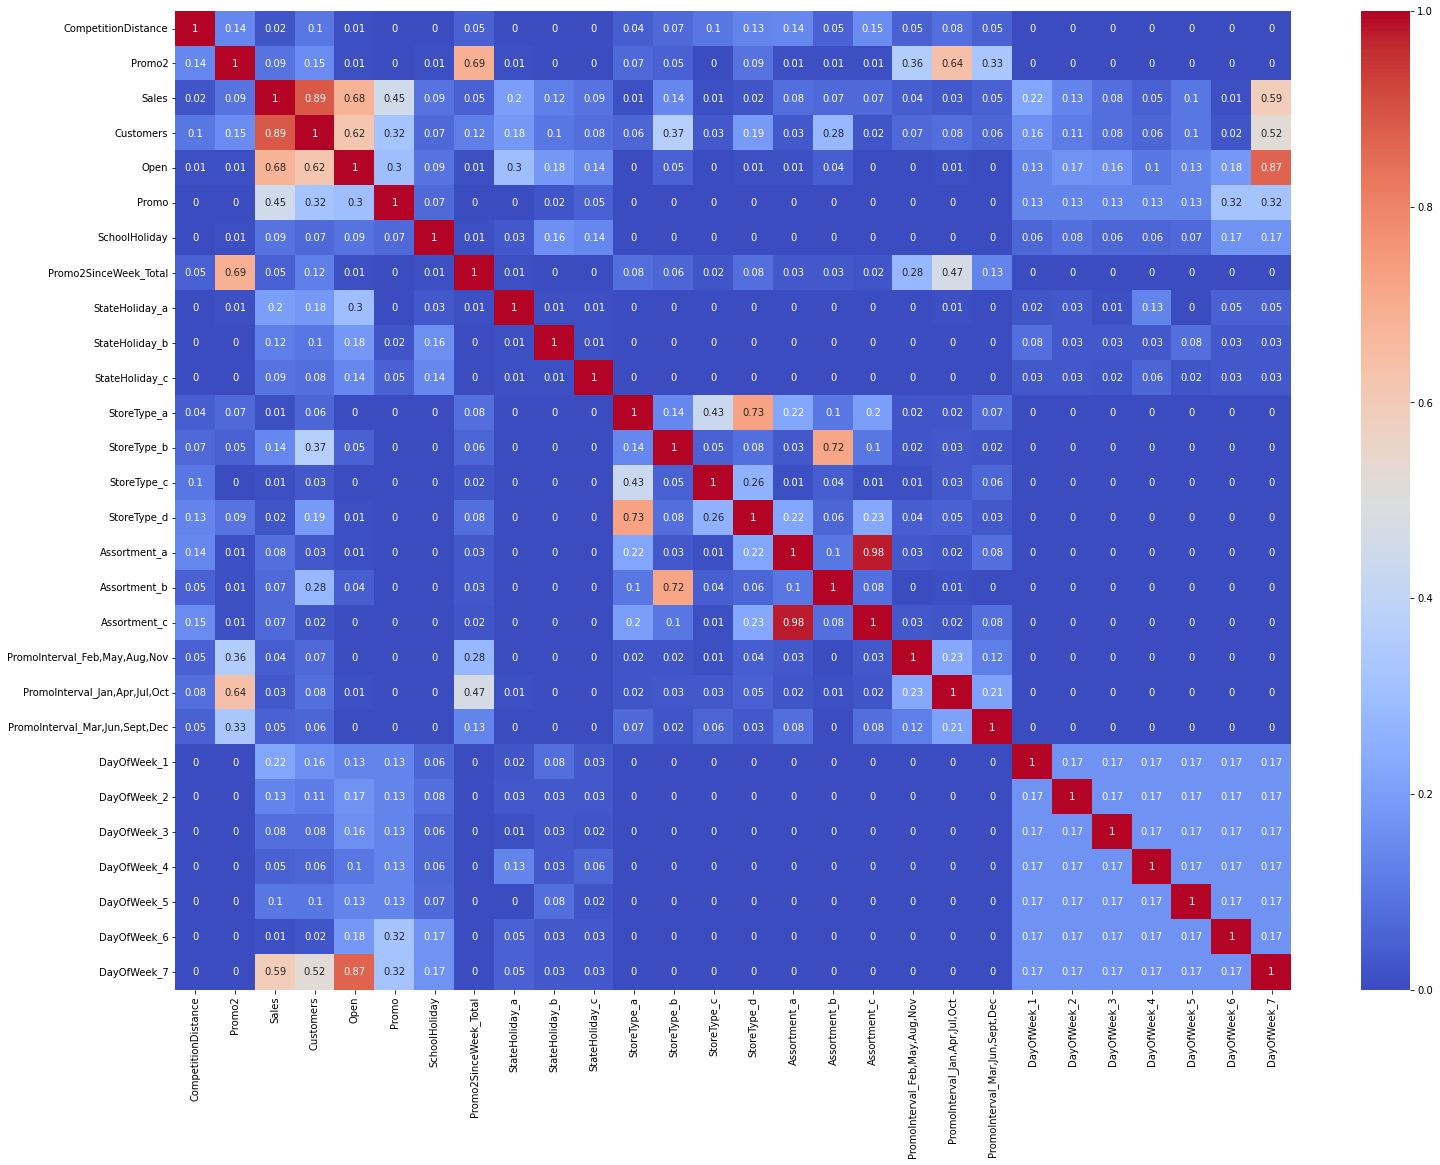

In [38]:
#correlation
plt.figure(figsize=(25,18))
correlation = round(Dataset.corr(),2)
sns.heatmap(abs(correlation), annot=True, cmap='coolwarm')

[Text(0, 0, 'Assortment_a vs. Assortment_c'),
 Text(0, 0, 'Sales vs. Customers'),
 Text(0, 0, 'Open vs. DayOfWeek_7'),
 Text(0, 0, 'StoreType_a vs. StoreType_d'),
 Text(0, 0, 'StoreType_b vs. Assortment_b'),
 Text(0, 0, 'Promo2 vs. Promo2SinceWeek_Total'),
 Text(0, 0, 'Sales vs. Open'),
 Text(0, 0, 'Promo2 vs. PromoInterval_Jan,Apr,Jul,Oct'),
 Text(0, 0, 'Customers vs. Open'),
 Text(0, 0, 'Sales vs. DayOfWeek_7'),
 Text(0, 0, 'Customers vs. DayOfWeek_7'),
 Text(0, 0, 'Promo2SinceWeek_Total vs. PromoInterval_Jan,Apr,Jul,Oct'),
 Text(0, 0, 'Sales vs. Promo')]

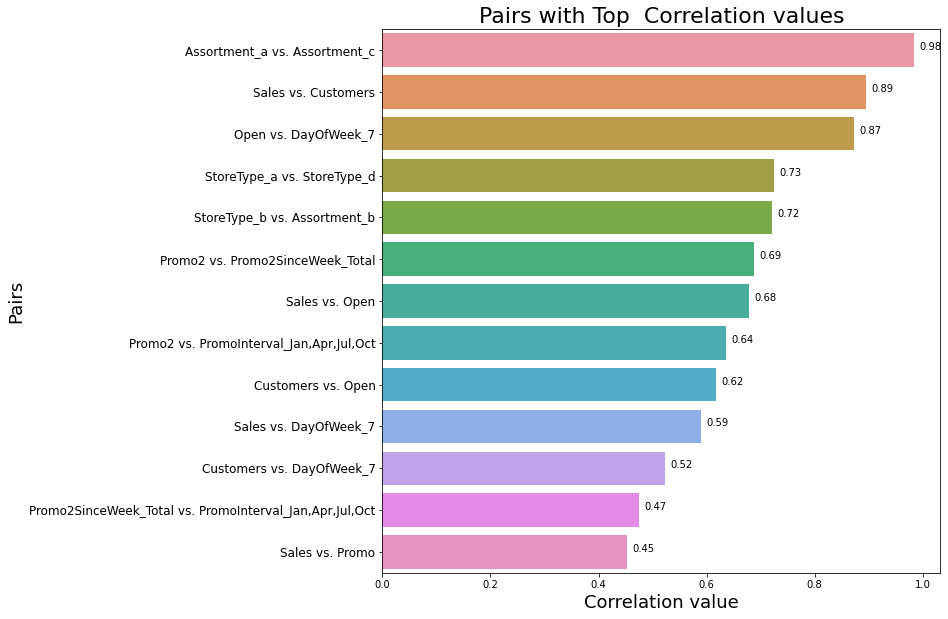

In [39]:
# calculating and plotting the highest value of correlation pairs
Corr_25=get_top_abs_correlations(Dataset,13)
Corr_25=Corr_25.reset_index()
Corr_25['Label']=Corr_25['level_0'].astype(str)+' vs. '+Corr_25['level_1'].astype(str)
Corr_25.drop(columns=['level_0','level_1'],inplace=True)
fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(x=0, y='Label', data=Corr_25)

def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.2f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.2f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)
show_values(ax,'h')
# # Decorations
ax.set_xlabel( 'Correlation value',fontdict = {'fontsize': 18})
ax.set_title( 'Pairs with Top  Correlation values',fontdict = {'fontsize': 22})
ax.set_ylabel('Pairs',fontdict = {'fontsize': 18})
ax.set_yticklabels(Corr_25['Label'],fontdict = {'fontsize': 12})


As we can see that The features with high correlation values are, 

1.   Assortment_a
2.   Assortment_c
3.   DayOfWeek_7
4.   Promo2

So they will be dropped for further analysis.



In [40]:
# dropping the variables with high correlation
Dataset.drop(columns=['Assortment_a','Assortment_c','DayOfWeek_7'],axis=1,inplace=True)
Dataset

,CompetitionDistance,Promo2,Sales,Customers,Open,Promo,SchoolHoliday,Promo2SinceWeek_Total,StateHoliday_a,StateHoliday_b,...,Assortment_b,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6
0,1270.0,0,5263,555,1,1,1,0.0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1270.0,0,5020,546,1,1,1,0.0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1270.0,0,4782,523,1,1,1,0.0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1270.0,0,5011,560,1,1,1,0.0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,1270.0,0,6102,612,1,1,1,0.0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,5350.0,1,4771,339,1,0,1,31.0,0,0,...,0,0,0,1,0,0,0,0,0,1
1017205,5350.0,1,4540,326,1,0,1,31.0,0,0,...,0,0,0,1,0,0,0,0,1,0
1017206,5350.0,1,4297,300,1,0,1,31.0,0,0,...,0,0,0,1,0,0,0,1,0,0
1017207,5350.0,1,3697,305,1,0,1,31.0,0,0,...,0,0,0,1,0,0,1,0,0,0


In [41]:
Dataset.drop(columns=['Promo2'],axis=1,inplace=True)